In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.python.framework import ops
import imghdr
import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib
from google.protobuf import text_format
import cv2
import copy

import os
import time
import math
from random import shuffle

print(tf.__version__)

1.12.0


In [2]:
class TrainingExample:
    def __init__(self, original_width, original_height):
        self.img      = None
        self.numfaces = 0
        
        self.encoding = np.zeros((7, 7, 7))
        self.encoding[..., 6] = 1
        
        self.original_width  = original_width
        self.original_height = original_height
        
        self.width  = 224.0
        self.height = 224.0
        
    def reshapeCoords(self, x, y, w, h):
        scaleWidth  = self.width  / float(self.original_width )
        scaleHeight = self.height / float(self.original_height)
        
        rx = x * scaleWidth
        ry = y * scaleHeight
        rh = h * scaleWidth
        rw = w * scaleHeight
        
        return rx, ry, rh, rw
        
    def setBoxNum(self, x, y, w, h):
        x = float(x) + (float(w) / 2.0)
        y = float(y) + (float(h) / 2.0)
        
        width  = float(w) / 2
        height = float(h) / 2
        
        boxX = math.floor(float(x) / 32.0)
        boxY = math.floor(float(y) / 32.0)
        
        if boxX > 6 or boxY > 6:
            return
        
        adjustedX = float((x - (boxX * 32.0)) / 32.0 )
        adjustedY = float((y - (boxY * 32.0)) / 32.0 )
        
        adjustedWidth  = float(w / self.width )# + (10.0 / self.width )
        adjustedHeight = float(h / self.height) + (10.0 / self.height)
        
        self.encoding[boxX][boxY][0] = 1
        self.encoding[boxX][boxY][1] = adjustedX
        self.encoding[boxX][boxY][2] = adjustedY
        self.encoding[boxX][boxY][3] = adjustedWidth
        self.encoding[boxX][boxY][4] = adjustedHeight


In [3]:
gd_file = './wider_face_train_bbx_gt.txt'
lines = []
with open(gd_file) as f:
    while True:
        line = f.readline()
        if line:
            lines.append(line)
        else:
            break
        
f.close()

In [5]:
original_img = cv2.imread('../data/widerfaces/0--Parade/0_Parade_marchingband_1_5.jpg')

light_img = original_img.copy()
dark_img = original_img.copy()

h, w, c = light_img.shape

color_bgra = (255, 255, 255)
color_dark = (0, 0, 0)

overlay      = np.full((h, w, 3), color_bgra, dtype='uint8')
overlay_dark = np.full((h, w, 3), color_dark, dtype='uint8')

cv2.addWeighted(overlay,      0.5, light_img, 0.5, 0, light_img)
cv2.addWeighted(overlay_dark, 0.5, dark_img,  0.5, 0, dark_img )

cv2.imwrite('light.jpg', light_img)
cv2.imwrite('dark.jpg', dark_img)
cv2.imwrite('original.jpg', original_img)

True

In [4]:
def get_transformed_images(training_example: TrainingExample, shift: int, original_width: float, original_height: float):
    img = training_example.img
    
    shifted_imgs = []
    color_imgs   = []
    
    h, w, c = img.shape
    
    t_left  = TrainingExample(original_width, original_height)
    t_right = TrainingExample(original_width, original_height)
    t_up    = TrainingExample(original_width, original_height)
    t_down  = TrainingExample(original_width, original_height)
    
    M_left_shift  = np.float32([[1, 0, -shift],[0, 1, 0     ]])
    M_right_shift = np.float32([[1, 0,  shift],[0, 1, 0     ]])
    M_up_shift    = np.float32([[1, 0,  0    ],[0, 1, -shift]])    
    M_down_shift  = np.float32([[1, 0,  0    ],[0, 1,  shift]])
    
    t_left.img  = cv2.warpAffine(img, M_left_shift , (w, h))
    t_right.img = cv2.warpAffine(img, M_right_shift, (w, h))    
    t_up.img    = cv2.warpAffine(img, M_up_shift   , (w, h))    
    t_down.img  = cv2.warpAffine(img, M_down_shift , (w, h))    
    
    shifted_imgs.append(t_left )
    shifted_imgs.append(t_right)
    shifted_imgs.append(t_up   )
    shifted_imgs.append(t_down )
    
    color_light = (255, 255, 255)
    color_dark  = (0,   0,   0  )

    overlay      = np.full((h, w, 3), color_light, dtype='uint8')
    overlay_dark = np.full((h, w, 3), color_dark , dtype='uint8')

    for shift in shifted_imgs:
        light_img = TrainingExample(original_width, original_height)
        dark_img  = TrainingExample(original_width, original_height)
        
        light_img.img = shift.img.copy()
        dark_img .img = shift.img.copy()
        
        overlay      = np.full((h, w, 3), color_light, dtype='uint8')
        overlay_dark = np.full((h, w, 3), color_dark, dtype='uint8')

        cv2.addWeighted(overlay,      0.5, light_img.img, 0.5, 0,  light_img.img)
        cv2.addWeighted(overlay_dark, 0.5, dark_img .img , 0.5, 0, dark_img.img )
        
        color_imgs.append(light_img)
        color_imgs.append(dark_img )
        
    transformed_imgs = shifted_imgs + color_imgs
    
    return transformed_imgs

In [9]:
original_img = cv2.imread('../data/widerfaces/0--Parade/0_Parade_marchingband_1_5.jpg')
original_img = cv2.resize(original_img, (224, 224))
t = TrainingExample(224, 224)

t.img = original_img

transformed_imgs = get_transformed_images(t, 10, 224, 224)

len(transformed_imgs)

12

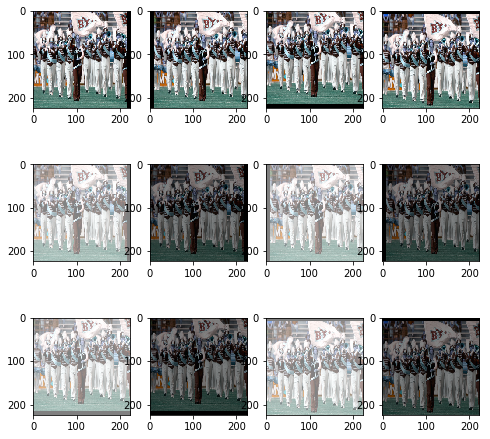

In [10]:
fig=plt.figure(figsize=(8, 8))

columns = 4
rows    = 3

for i, img in enumerate(transformed_imgs):
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(img.img)
    
plt.show()

In [11]:
examples = []

i = 0

color_light = (255, 255, 255)
color_dark  = (0, 0, 0)

while i < len(lines):
    filename = lines[i    ]
    numfaces = lines[i + 1]
    
    filename = 'C:/facial_recognition/inputs/widerfaces/' + filename
    filename = filename.replace('\n', '')
    numfaces = numfaces.replace('\n', '')
    img      = cv2.imread(filename)
    
    originalHeight, originalWidth, c = img.shape
    img = cv2.resize(img, (224, 224))
    
    t          = TrainingExample(originalWidth, originalHeight)
    t.img      = img
    t.numfaces = numfaces
    overScaled = False
    
    i+=2
    if int(numfaces) >= 10:
        i+= int(numfaces)
        continue
        
    if int(numfaces) == 0:
        i += 1
        continue
        
    transformed_imgs = get_transformed_images(t, 10, originalWidth, originalHeight)
    
    for face in range(int(numfaces)):
        coordinates = lines[i]
        coordinates = coordinates.replace('\n', '')
        splitCoordinates = coordinates.split(' ')

        x = float(splitCoordinates[0])
        y = float(splitCoordinates[1])
        h = float(splitCoordinates[2])
        w = float(splitCoordinates[3])
        
        widthRatio  = originalWidth  / 224.0
        heightRatio = originalHeight / 224.0
        
        horizontalShift = 10.0 * widthRatio
        verticalShift   = 10.0 * heightRatio

        r       = t.reshapeCoords(x,                   y,                 h, w)
        r_left  = t.reshapeCoords(x - horizontalShift, y,                 h, w)
        r_right = t.reshapeCoords(x + horizontalShift, y,                 h, w)
        r_up    = t.reshapeCoords(x,                   y - verticalShift, h, w)
        r_down  = t.reshapeCoords(x,                   y + verticalShift, h, w)
        
        if r is not None:
            t                   .setBoxNum(r      [0], r      [1], r      [2], r      [3])
            transformed_imgs[0 ].setBoxNum(r_left [0], r_left [1], r_left [2], r_left [3])
            transformed_imgs[4 ].setBoxNum(r_left [0], r_left [1], r_left [2], r_left [3])
            transformed_imgs[5 ].setBoxNum(r_left [0], r_left [1], r_left [2], r_left [3])
            transformed_imgs[1 ].setBoxNum(r_right[0], r_right[1], r_right[2], r_right[3])
            transformed_imgs[6 ].setBoxNum(r_right[0], r_right[1], r_right[2], r_right[3])
            transformed_imgs[7 ].setBoxNum(r_right[0], r_right[1], r_right[2], r_right[3])
            transformed_imgs[2 ].setBoxNum(r_up   [0], r_up   [1], r_up   [2], r_up   [3])
            transformed_imgs[8 ].setBoxNum(r_up   [0], r_up   [1], r_up   [2], r_up   [3])
            transformed_imgs[9 ].setBoxNum(r_up   [0], r_up   [1], r_up   [2], r_up   [3])
            transformed_imgs[3 ].setBoxNum(r_down [0], r_down [1], r_down [2], r_down [3])
            transformed_imgs[10].setBoxNum(r_down [0], r_down [1], r_down [2], r_down [3])
            transformed_imgs[11].setBoxNum(r_down [0], r_down [1], r_down [2], r_down [3])
            
        else:
            overScaled = True
        i += 1

    if not overScaled and originalHeight > 224 and originalWidth > 224:
        transformed_imgs.append(t)
        examples = examples + transformed_imgs

print(len(examples))

126893


In [12]:
def getEncodingInformation(encoding):
    pc      = encoding[..., :1]
    boxes   = encoding[..., 1:5]
    
    return pc, boxes

In [13]:
def visualize_bounding_box(img, encoding):
    c_img = img.copy()
    
    pc, boxes = getEncodingInformation(encoding)
    
    max_c = -1.0
    
    for i in range(pc.shape[0]):
        for j in range(pc.shape[1]):
            cur_pc  = pc   [i, j]
            cur_box = boxes[i, j]
                        
            if cur_pc > 0.6:
                x      = 0 if cur_box[0] < 0 else int(cur_box[0] * 32.0 + (i * 32.0))
                y      = 0 if cur_box[1] < 0 else int(cur_box[1] * 32.0 + (j * 32.0))
                width  = 0 if cur_box[2] < 0 else int(cur_box[2] * 224.0)
                height = 0 if cur_box[3] < 0 else int(cur_box[3] * 224.0)
                
                #print(str(x) + ", " + str(y) + ", " + str(width) + ", " + str(height))
                
                cv2.rectangle(c_img, (x - width, y - height), (x + width, y + height), (0, 255, 0), 2)
                
    plt.imshow(c_img)

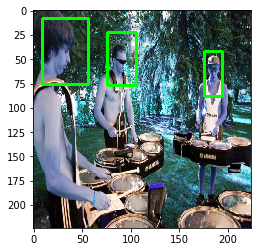

In [14]:
index = 1000
visualize_bounding_box(examples[index].img, examples[index].encoding)

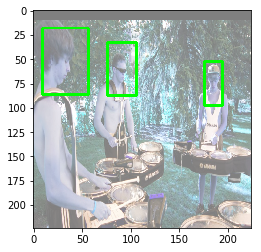

In [15]:
index = 998
visualize_bounding_box(examples[index].img, examples[index].encoding)

In [16]:
def getEncodings(examples, batch, batch_size):
    encodings = []
    
    start = batch       * batch_size
    end   = (batch + 1) * batch_size

    if end > len(examples):
        end = len(examples)
    
    subset = examples[start:end]
    
    for example in subset:
        encodings.append(example.encoding)

    return encodings

In [17]:
def get_cost(labels, outputs):
    positive_labels = tf.equal(labels[..., 0], 1.0)
    negative_labels = tf.equal(labels[..., 0], 0.0)
    
    pos_labels  = tf.boolean_mask(labels, positive_labels)
    pos_outputs = tf.boolean_mask(outputs, positive_labels)
    
    neg_labels  = tf.boolean_mask(labels, negative_labels)
    neg_outputs = tf.boolean_mask(outputs, negative_labels)
    
    cost = tf.reduce_sum(0.3 * tf.losses.mean_squared_error(neg_labels[..., 0], neg_outputs[..., 0]) + tf.losses.mean_squared_error(pos_labels[..., 0], pos_outputs[..., 0]) + tf.losses.mean_squared_error(pos_labels[..., 1:5], pos_outputs[..., 1:5]))

    return cost

TRANSFER LEARNING

In [18]:
import sys

sys.path.append('C:/modules/tensornets/')

In [19]:
import tensornets as nets

In [20]:
def create_resnet_placeholders():
    x = tf.placeholder(shape = [None, 224, 224, 3], dtype = 'float', name = 'input_image'          )
    y = tf.placeholder(shape = [None, 7, 7, 7    ], dtype = 'float', name = 'ground_truth_encoding')
    
    return x, y

In [21]:
def getResImages(examples, batch, batch_size, model):
    images = []
    
    start = batch       * batch_size
    end   = (batch + 1) * batch_size
    
    if end > len(examples):
        end = len(examples)
    
    subset = examples[start:end]
    
    for example in subset:
        images.append(example.img)
    
    return images

In [23]:
def transfer_model_yolo(training_examples, learning_rate = 1e-4, num_epochs = 5, batch_size = 32):
    ops.reset_default_graph()
    m = len(training_examples)
    
    batch_images, batch_encodings = create_resnet_placeholders()
    kp                            = tf.placeholder(dtype='bool', name='kp')
    
    res_model = nets.ResNet50(batch_images, is_training=True)
    output = res_model.get_outputs()[158]
        
    with tf.variable_scope('training_vars'):
        output = tf.layers.dense  (output, 1500)
        output = tf.layers.batch_normalization(output)
        output = tf.nn.relu(output)
        output = tf.layers.dropout(output, training=kp)
        output = tf.layers.dense  (output, 1000)
        output = tf.layers.batch_normalization(output)
        output = tf.nn.relu(output)
        output = tf.layers.dropout(output, training=kp)
        output = tf.layers.dense(output, 343)
        output = tf.layers.batch_normalization(output)
        output = tf.nn.sigmoid(output)
        output = tf.reshape(output, (-1, 7, 7, 7), name='final_output')
    
    training_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'training_vars')
    
    cost = get_cost(batch_encodings, output)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)#, var_list=training_vars)
    
    saver = tf.train.Saver()
    
    init  = tf.global_variables_initializer()

    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))# as sess:
    sess.run(init)
    sess.run(res_model.pretrained())
    
    tf.train.write_graph(sess.graph.as_graph_def(), './tmp/input_model', 'input_yolo_graph.pbtxt', True)
    
    for epoch in range(num_epochs):    
        epoch_cost = 0
        num_batches = (int)(m / batch_size)
        shuffle(training_examples)
        for batch in range(num_batches):
            images    = getResImages(training_examples, batch, batch_size, res_model)
            encodings = getEncodings(training_examples, batch, batch_size)
            
            _, batch_cost = sess.run([optimizer, cost], feed_dict = { batch_images : images, batch_encodings : encodings, kp : True})
            epoch_cost += batch_cost / num_batches
        
        if epoch % 10 == 0:
            #TODO: print current time
            print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            print ()
            print ("---------------------------------------------")
            print ()
            saver.save(sess, './tmp/yolo.ckpt')
            
    saver.save(sess, './tmp/yolo.ckpt')

In [24]:
train_examples = examples
#test_examples  = examples[-680: ]

transfer_model_yolo(train_examples, num_epochs=50, batch_size=32)

c:\deep_learning_workspace\deep_learning_env\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Cost after epoch 0: 0.136658

---------------------------------------------

Cost after epoch 10: 0.033674

---------------------------------------------

Cost after epoch 20: 0.025072

---------------------------------------------

Cost after epoch 30: 0.021167

---------------------------------------------

Cost after epoch 40: 0.019052

---------------------------------------------



In [85]:
test_inputs = tf.placeholder(tf.float32, (None, 224, 224, 3))
test_input = train_examples[12345].img

In [86]:
h, w, c = test_input.shape

light_img = test_input.copy()
dark_img  = test_input.copy()
                        
color_light = (255, 255, 255)
color_dark  = (0, 0, 0)

overlay_light = np.full((h, w, 3), color_light, dtype='uint8')
overlay_dark  = np.full((h, w, 3), color_dark , dtype='uint8')

cv2.addWeighted(overlay_light, 0.5, light_img, 0.5, 0, light_img)
cv2.addWeighted(overlay_dark , 0.5, dark_img,  0.5, 0, dark_img )
                        
test_input = np.reshape(test_input, (1,224,224, 3))

In [87]:
ops.reset_default_graph()

with tf.Session() as sess:
    saver = tf.train.import_meta_graph('./tmp/yolo.ckpt.meta')
    saver.restore(sess, './tmp/yolo.ckpt')
    graph = tf.get_default_graph()
    out = graph.get_tensor_by_name('training_vars/final_output:0')
    
    encoding = sess.run(out, feed_dict = { 'input_image:0' : test_input, 'kp:0' : False })

INFO:tensorflow:Restoring parameters from ./tmp/yolo.ckpt


In [88]:
sencoding = encoding[0]

In [89]:
test_input.shape

(1, 224, 224, 3)

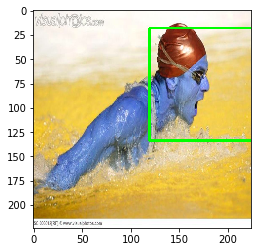

In [90]:
visualize_bounding_box(test_input[0], sencoding)

In [104]:
i = cv2.imread(test_examples[6].path)
plt.imshow(i)

NameError: name 'test_examples' is not defined